# Osciliations of the platform

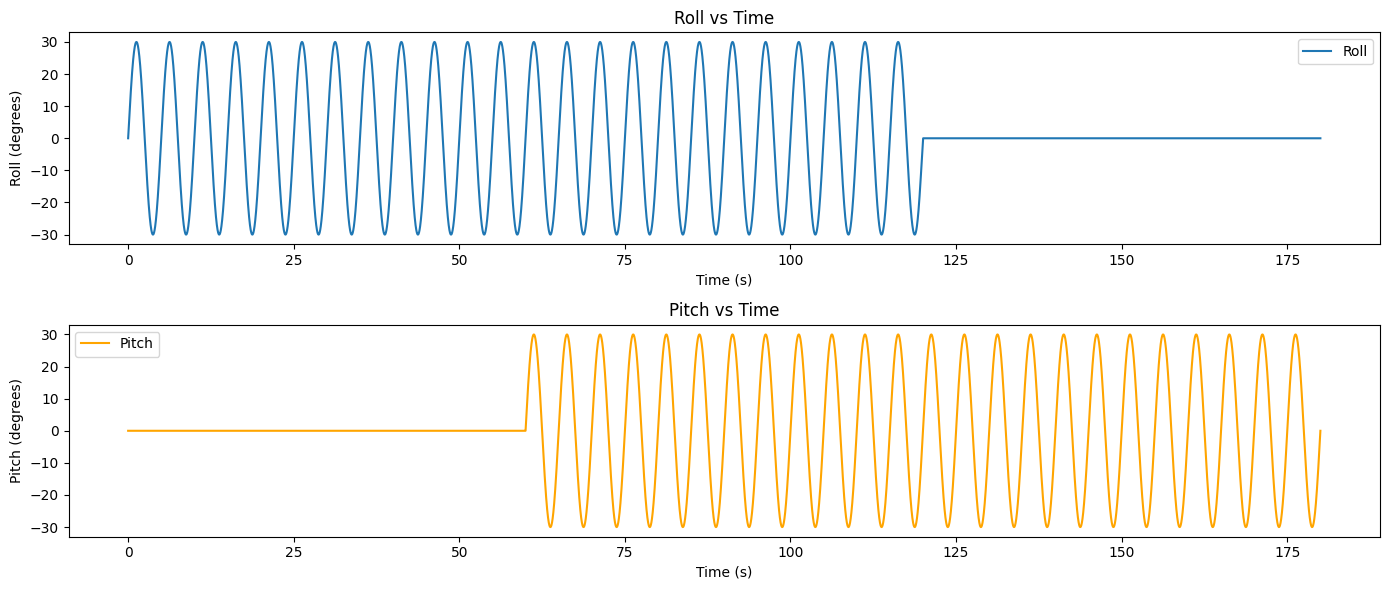

In [36]:
import numpy as np
import matplotlib.pyplot as plt

frequency = 0.2
cycle_time = 1/ frequency
a = 2 * np.pi / cycle_time

n_cycles = 12
t_roll = n_cycles * cycle_time

t_pause = 0

t_total = 4 * t_pause + 3 * (n_cycles * cycle_time)

def roll(t, t_pause, t_roll, a):
    if t < t_pause:
        return 0 
    if t < t_pause + t_roll:
        return 30 * np.sin(a * t)
    if t < 2 * t_pause + t_roll:
        return 0
    if t < 2 * (t_pause + t_roll):
        return 30 * np.sin(a * t)
    return  0

def pitch(t, t_pause, t_roll, a):
    if t < 2 * t_pause + t_roll:
        return 0
    if t < 2 * (t_pause + t_roll):
        return 30 * np.sin(a * t)
    if t < 3 * t_pause + 2 * t_roll:
        return 0
    if t < 3 * (t_pause + t_roll):
        return 30 * np.sin(a * t)
    return 0

sample_time = t_total
sample_frequency = 100
total_samples = sample_time * sample_frequency

time = np.linspace(0, t_total, int(total_samples))

# Calculate roll and pitch arrays
roll_array = np.array([roll(t, t_pause, t_roll, a) for t in time])
pitch_array = np.array([pitch(t, t_pause, t_roll, a) for t in time])

plt.figure(figsize=(14, 6))

# Plot roll_array
plt.subplot(2, 1, 1)
plt.plot(time, roll_array, label='Roll')
plt.xlabel('Time (s)')
plt.ylabel('Roll (degrees)')
plt.title('Roll vs Time')
plt.legend()

# Plot pitch_array
plt.subplot(2, 1, 2)
plt.plot(time, pitch_array, label='Pitch', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (degrees)')
plt.title('Pitch vs Time')
plt.legend()

plt.tight_layout()
plt.show()

# Model the accuracy of the accelerometers

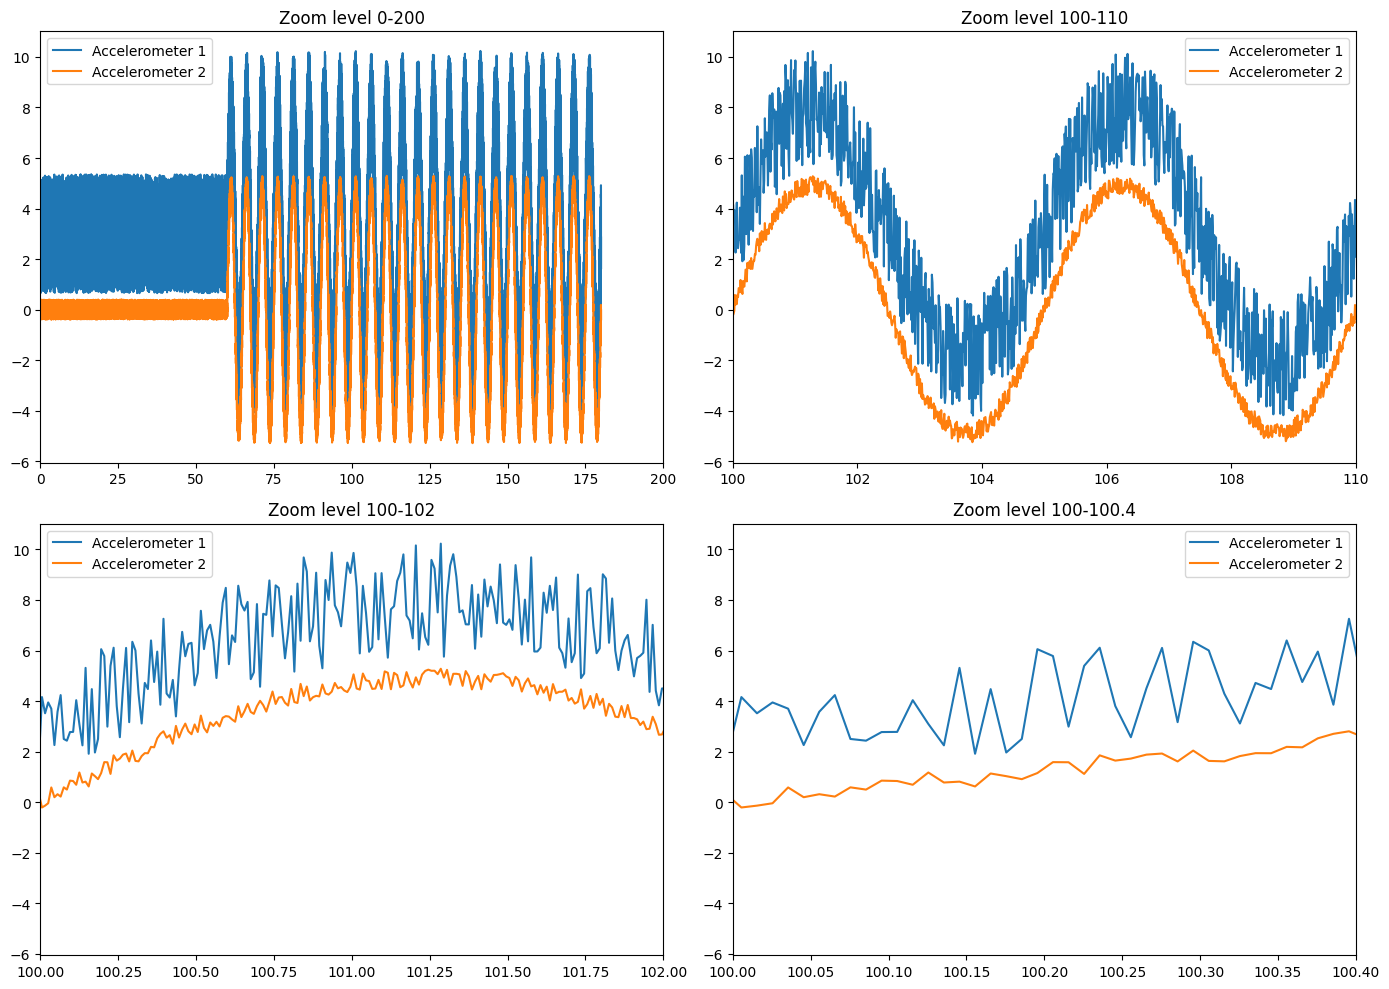

In [37]:
gravity = 9.807
accel_x = gravity * np.sin(pitch_array * np.pi/180)
accel_max_measurement = 8 * gravity

accelerometer_1 = 0.03 * accel_max_measurement
accelerometer_2 = 0.005 * accel_max_measurement
accel_offset_1 = 3
accel_offset_2 = 0

m_accel_x_1 = accel_x + accel_offset_1 + (1 - (2 * np.random.rand(len(accel_x)))) * accelerometer_1
m_accel_x_2 = accel_x + accel_offset_2 + (1 - (2 * np.random.rand(len(accel_x)))) * accelerometer_2

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Zoom level 0-200
axs[0, 0].plot(time, m_accel_x_1, label='Accelerometer 1')
axs[0, 0].plot(time, m_accel_x_2, label='Accelerometer 2')
axs[0, 0].set_xlim(0, 200)
axs[0, 0].set_title('Zoom level 0-200')
axs[0, 0].legend()

# Plot 2: Zoom level 100-110
axs[0, 1].plot(time, m_accel_x_1, label='Accelerometer 1')
axs[0, 1].plot(time, m_accel_x_2, label='Accelerometer 2')
axs[0, 1].set_xlim(100, 110)
axs[0, 1].set_title('Zoom level 100-110')
axs[0, 1].legend()

# Plot 3: Zoom level 100-102
axs[1, 0].plot(time, m_accel_x_1, label='Accelerometer 1')
axs[1, 0].plot(time, m_accel_x_2, label='Accelerometer 2')
axs[1, 0].set_xlim(100, 102)
axs[1, 0].set_title('Zoom level 100-102')
axs[1, 0].legend()

# Plot 4: Zoom level 100-100.4
axs[1, 1].plot(time, m_accel_x_1, label='Accelerometer 1')
axs[1, 1].plot(time, m_accel_x_2, label='Accelerometer 2')
axs[1, 1].set_xlim(100, 100.4)
axs[1, 1].set_title('Zoom level 100-100.4')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# LMS adaptive filter

Final weights (w): [0.15914178 0.15986775 0.16089677 0.16144921 0.16155073 0.16197119]
First 10 filtered values (y): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
First 10 errors (e): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


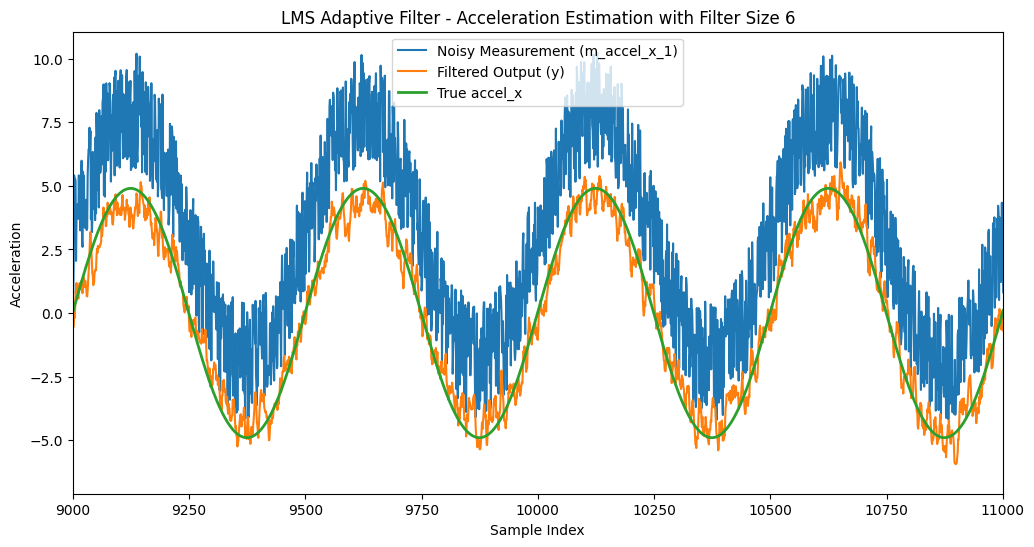

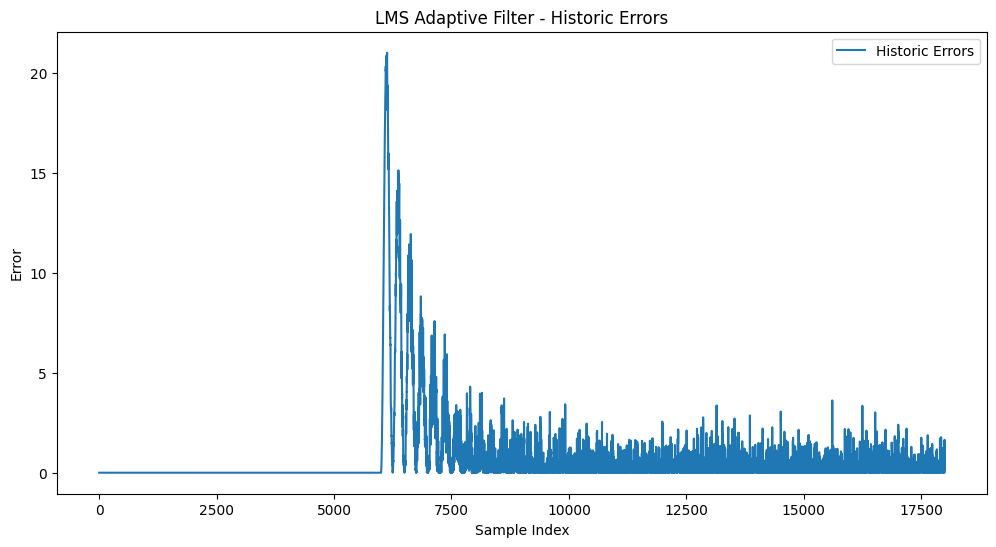

In [38]:
average_1 = np.mean(m_accel_x_1)
average_2 = np.mean(m_accel_x_2)

m_accel_x_centered_1 = m_accel_x_1 - average_1


filter_size = 6
learning_rate = 0.00001
# Initialize weights (w) as a vector of zeros with length equal to filter size
w = np.zeros(filter_size)

# Arrays to store results
y_array = np.zeros(len(accel_x))     # Filtered outputs
error_array = np.zeros(len(accel_x)) # Errors

# Initialize input buffer with zeros to hold the last `filter_size` inputs
input_buffer = np.zeros(filter_size)

historic_errors = []
# LMS adaptation loop
for k in range(len(m_accel_x_centered_1)):
    # Update input buffer with the current measurement
    input_buffer = np.roll(input_buffer, -1)  # Shift left
    input_buffer[-1] = m_accel_x_centered_1[k]         # Add new measurement at the end

    # Desired output at this time step
    d_k = accel_x[k]

    # Calculate the output y(k) = w.T * x (dot product of weights and input buffer)
    y_k = np.dot(w, input_buffer)

    # Calculate the error e(k) = d(k) - y(k)
    # gotta square this
    e_k = (d_k - y_k)

    # Update weights with w(k+1) = w(k) + μ * e(k) * x
    w += learning_rate * e_k * input_buffer

    # Store results
    y_array[k] = y_k
    error_array[k] = e_k

    historic_errors.append(e_k ** 2)

# Display final weights and a sample of the filtered output
print("Final weights (w):", w)
print("First 10 filtered values (y):", y_array[:10])
print("First 10 errors (e):", error_array[:10])

# Plot results to visualize the filtering process
plt.figure(figsize=(12, 6))
plt.plot(m_accel_x_1, label='Noisy Measurement (m_accel_x_1)')
plt.plot(y_array, label='Filtered Output (y)')
plt.plot(accel_x, label='True accel_x', linewidth=2)
plt.xlim(9000, 11000)
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Acceleration')
plt.title('LMS Adaptive Filter - Acceleration Estimation with Filter Size 6')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(historic_errors, label='Historic Errors')
plt.xlabel('Sample Index')
plt.ylabel('Error')
plt.title('LMS Adaptive Filter - Historic Errors')
plt.legend()
plt.show()


# Part 2
## the images

(315, 560)


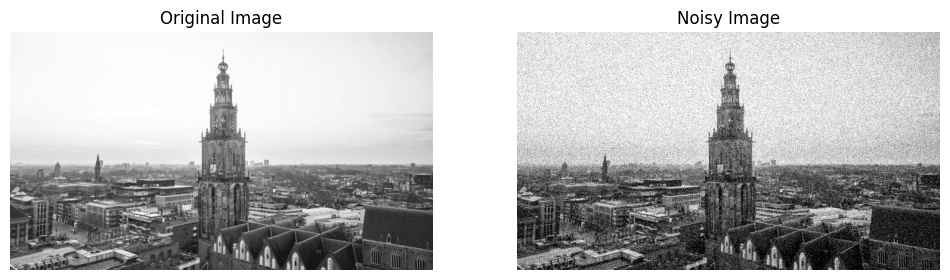

In [39]:
from PIL import Image
import IPython.display as display

# Load the image
image = Image.open('test_image_bw.jpg')

raw_image = np.array(image)
print(raw_image.shape)
desired_image = raw_image - np.mean(raw_image)
noise_level = 20
noise = np.random.normal(-noise_level, noise_level, desired_image.shape)
noisy_image = raw_image + noise

# Convert noisy_image to uint8 and clip values to be in the valid range [0, 255]
noisy_image_uint8 = np.clip(noisy_image, 0, 255).astype(np.uint8)

input_image = desired_image + noise

# Display the image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(noisy_image_uint8, cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

plt.show()
# # Resize the image by 70%
# width, height = image.size
# new_size = (int(width * 0.5), int(height * 0.5))
# resized_image = image.resize(new_size)

# # Convert the image to black and white
# bw_image = resized_image.convert('L')

# # Save the black and white image
# bw_image.save('test_image_bw.jpg')

In [40]:
def mirror_alternate_rows(image):
    img_array = np.array(image)
    
    # Get the height and width of the image
    height, width = img_array.shape
    
    # Mirror every other row starting from the second row
    for row in range(1, height, 2):
        img_array[row] = img_array[row][::-1]
    
    # Convert the modified array back to an image
    # mirrored_img = Image.fromarray(img_array)
    return img_array

def lms_filter_1d(input_image, desired_image, filter_size=3, learning_rate=0.01, start_weights=None, print_error=False, update_weights=True):
    if start_weights is not None:
        weights = start_weights
    else:
        weights = np.zeros(filter_size)
    
    input_image = mirror_alternate_rows(input_image)
    desired_image = mirror_alternate_rows(desired_image)
    
    error_history = np.zeros(input_image.shape[0] * input_image.shape[1])
    output_weights = None
    
    input_flat = input_image.flatten()
    desired_flat = desired_image.flatten()
    output_image_flat = np.zeros_like(input_flat)
    input_buffer = np.zeros(filter_size)
    
    for i in range(len(input_flat)):
        # Update input buffer with the current measurement
        input_buffer = np.roll(input_buffer, -1)  # Shift left
        input_buffer[-1] = input_flat[i]         # Add new measurement at the end

        # Desired output at this time step
        d_k = desired_flat[i]

        # Calculate the output y(k) = w.T * x (dot product of weights and input buffer)
        y_k = np.dot(weights, input_buffer)

        # Calculate the error e(k) = d(k) - y(k)
        # gotta square this
        e_k = (d_k - y_k)

        if e_k < 10 and output_weights is None:
               output_weights = weights
           
        if abs(e_k) < 1e-10:
            if e_k > 0:
                e_k = 0.1e-10
            else:
                e_k = -0.1e-10
        
        if abs(e_k) > 1e150:
            if e_k > 0:
                e_k = 1e150
            else:
                e_k = -1e150
                
        # Update weights with w(k+1) = w(k) + μ * e(k) * x
        weights += learning_rate * e_k * input_buffer

        # Store results
        output_image_flat[i] = y_k
        error_history[i] = e_k ** 2

    return mirror_alternate_rows(np.reshape(output_image_flat, (input_image.shape[0], input_image.shape[1]))), error_history, output_weights 

    # instead of using a 1D filter, we will use a 2D filter with a square window
def lms_filter_2d(input_image, desired_image, filter_size=3, learning_rate=0.01, start_weights=None, print_error=False, update_weights=True):
    """
    Apply LMS filtering on a 2D image with a given filter size and learning rate.

    Parameters:
    - input_image (2D array): Noisy or raw input image.
    - desired_image (2D array): Target or desired output image (e.g., clean version).
    - filter_size (int): Size of the square filter window (e.g., 3 for a 3x3 window).
    - learning_rate (float): Learning rate for the LMS algorithm.

    Returns:
    - output_image (2D array): Filtered output image.
    - error_image (2D array): Error image showing the error at each pixel.
    """
    # Initialize filter weights (e.g., zeros) with shape (filter_size, filter_size)
    if start_weights is not None:
        weights = start_weights
    else:
        weights = np.zeros((filter_size, filter_size))

    # Padding size for the image borders
    pad_size = filter_size // 2
    padded_input = np.pad(input_image, pad_size, mode='constant', constant_values=0)

    # Prepare output images
    output_image = np.zeros_like(input_image)
    error_history = np.zeros(input_image.shape[0] * input_image.shape[1])
    output_weights = None

    # Loop over each pixel in the input image (excluding padding)
    for i in range(pad_size, padded_input.shape[0] - pad_size):
        # Determine the order of columns for this row (left to right or right to left)
        if (i - pad_size) % 2 == 0:  # Even row: left to right
            column_range = range(pad_size, padded_input.shape[1] - pad_size)
        else:  # Odd row: right to left
            column_range = range(padded_input.shape[1] - pad_size - 1, pad_size - 1, -1)

        for j in column_range:
            # Extract the current filter window (input buffer)
            input_buffer = padded_input[i - pad_size:i + pad_size + 1, j - pad_size:j + pad_size + 1]

            # Desired output (target pixel value)
            d_k = desired_image[i - pad_size, j - pad_size]

            # Calculate the output y(k) = sum(weights * input_buffer)
            # Instead of using np.dot, we can flatten the arrays and use np.sum
            y_k = np.sum(weights * input_buffer)

            # Calculate the error e(k) = d(k) - y(k)
            e_k = d_k - y_k
            if e_k < 10 and output_weights is None:
                output_weights = weights
            
            if abs(e_k) < 1e-10:
                if e_k > 0:
                    e_k = 0.1e-10
                else:
                    e_k = -0.1e-10
            
            if abs(e_k) > 1e150:
                if e_k > 0:
                    e_k = 1e150
                else:
                    e_k = -1e150

            with np.errstate(invalid='raise'):
                try:
                    # Update weights with LMS rule: w(k+1) = w(k) + μ * e(k) * input_buffer
                    if update_weights:
                        previous_weights = weights
                        weights += learning_rate * e_k * input_buffer
                except:
                    if print_error:
                        print("Error at ", i, j)
                        print("weights", weights)
                        print("learning_rate", learning_rate)
                        print("e_k", e_k)
                        print("input_buffer", input_buffer)
                        print("d_k", d_k)
                        print("y_k", y_k)
                        print("previous_weights", previous_weights)

            # Store the output and error in their respective images
            output_image[i - pad_size, j - pad_size] = y_k
            error_history[(i - pad_size) * input_image.shape[1] + (j - pad_size)] = e_k ** 2
    return output_image, error_history, output_weights 

# Using a 1 dimensional filter

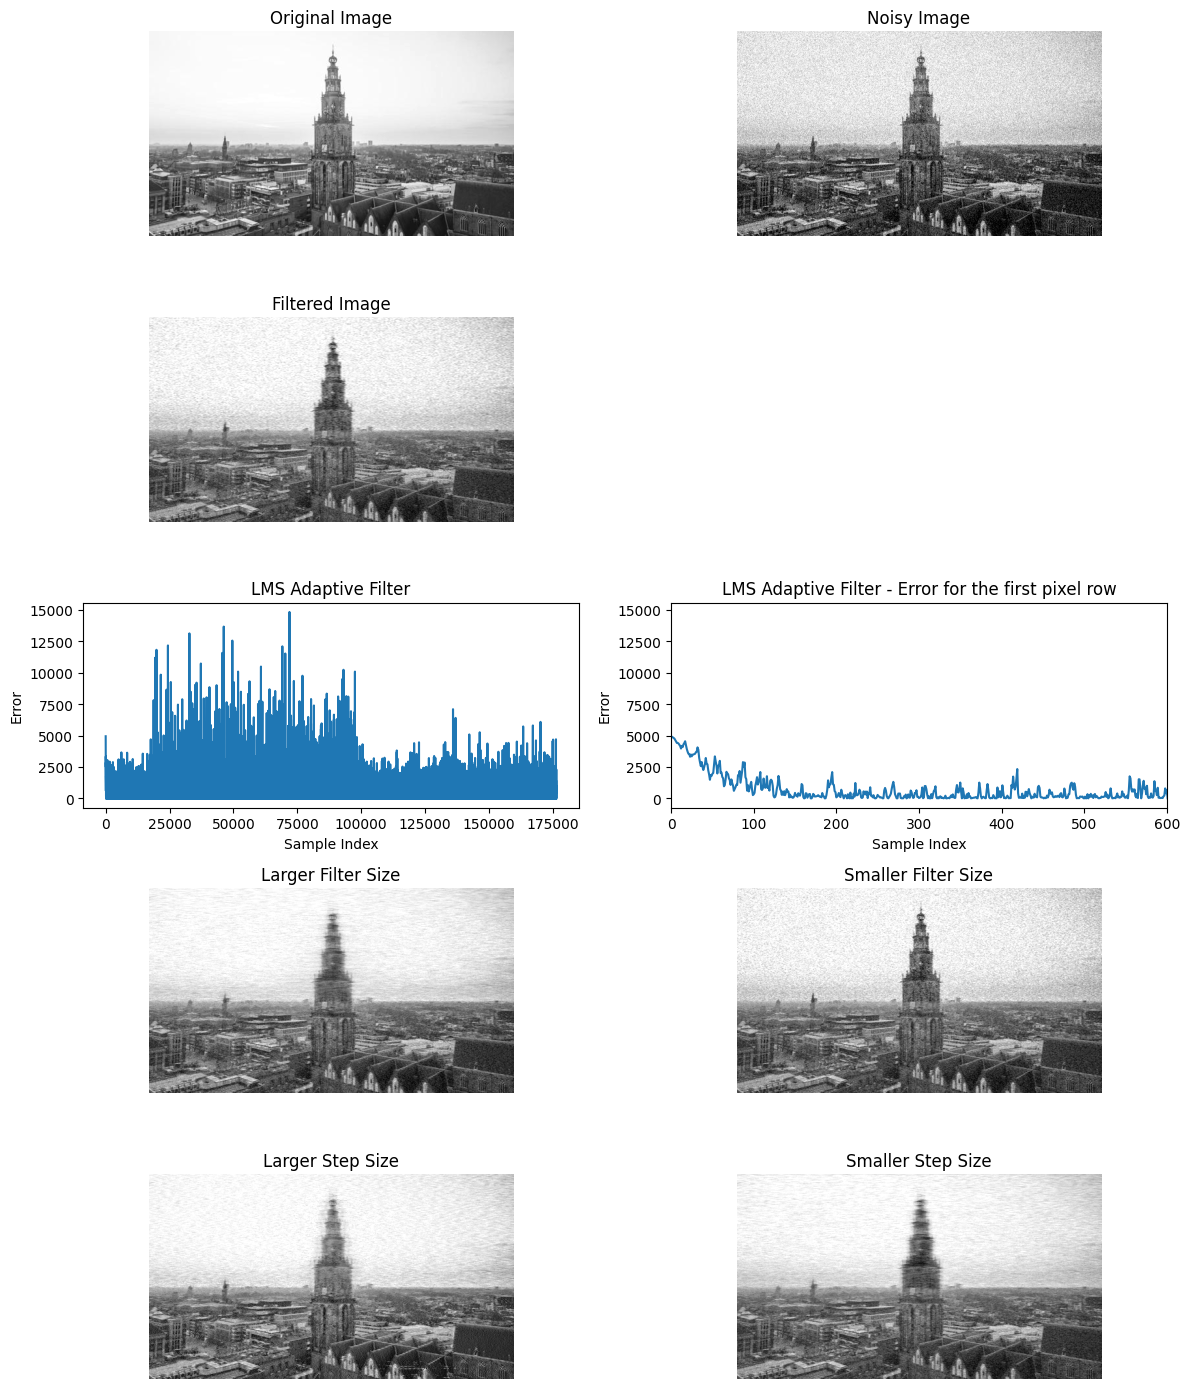

In [41]:
filtered_image, error_history, weights = lms_filter_1d(input_image, desired_image, 3, 0.000001, None)
larger_step, _,_ = lms_filter_1d(input_image, desired_image, 7, 0.00001, None, True)
smaller_step, _,_ = lms_filter_1d(input_image, desired_image, 7, 0.0000001, None)
larger_filter, _,_ = lms_filter_1d(input_image, desired_image, 9, 0.000001, None)
smaller_filter, _,_ = lms_filter_1d(input_image, desired_image, 2, 0.000001, None)



# Reshape the output to the original image shape
output_image = filtered_image.reshape(raw_image.shape)
output_image += np.mean(raw_image)
# Clip values to be in the valid range [0, 255] and convert to uint8
output_image_uint8 = np.clip(output_image, 0, 255).astype(np.uint8)

larger_step = larger_step.reshape(raw_image.shape)
larger_step += np.mean(raw_image)
larger_step = np.clip(larger_step, 0, 255).astype(np.uint8)

smaller_step = smaller_step.reshape(raw_image.shape)
smaller_step += np.mean(raw_image)
smaller_step = np.clip(smaller_step, 0, 255).astype(np.uint8)

larger_filter = larger_filter.reshape(raw_image.shape)
larger_filter += np.mean(raw_image)
larger_filter = np.clip(larger_filter, 0, 255).astype(np.uint8)

smaller_filter = smaller_filter.reshape(raw_image.shape)
smaller_filter += np.mean(raw_image)
smaller_filter = np.clip(smaller_filter, 0, 255).astype(np.uint8)

# Display the original, noisy, and output images
fig, ax = plt.subplots(5, 2, figsize=(12, 14))
ax[0, 0].imshow(raw_image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(noisy_image_uint8, cmap='gray')
ax[0, 1].set_title('Noisy Image')
ax[0, 1].axis('off')

ax[1, 0].imshow(output_image_uint8, cmap='gray')
ax[1, 0 ].set_title('Filtered Image')
ax[1, 0].axis('off')

ax[1, 1].axis('off')

ax[2, 0].plot(error_history, label='Errors')
ax[2, 0].set_xlabel('Sample Index')
ax[2, 0].set_ylabel('Error')
ax[2, 0].set_title('LMS Adaptive Filter')

ax[2, 1].plot(error_history, label='Errors')
ax[2, 1].set_xlabel('Sample Index')
ax[2, 1].set_ylabel('Error')
ax[2, 1].set_title('LMS Adaptive Filter - Error for the first pixel row')
ax[2, 1].set_xlim(0, 600)

# Plot larger_filter
ax[3, 0].imshow(larger_filter, cmap='gray')
ax[3, 0].set_title('Larger Filter Size')
ax[3, 0].axis('off')

# Plot smaller_filter
ax[3, 1].imshow(smaller_filter, cmap='gray')
ax[3, 1].set_title('Smaller Filter Size')
ax[3, 1].axis('off')

# Plot larger_step
ax[4, 0].imshow(larger_step, cmap='gray')
ax[4, 0].set_title('Larger Step Size')
ax[4, 0].axis('off')

# Plot smaller_step
ax[4, 1].imshow(smaller_step, cmap='gray')
ax[4, 1].set_title('Smaller Step Size')
ax[4, 1].axis('off')

fig.tight_layout()
plt.show()


# Using a 2D filter
This filter will still zig-zag across the image. 

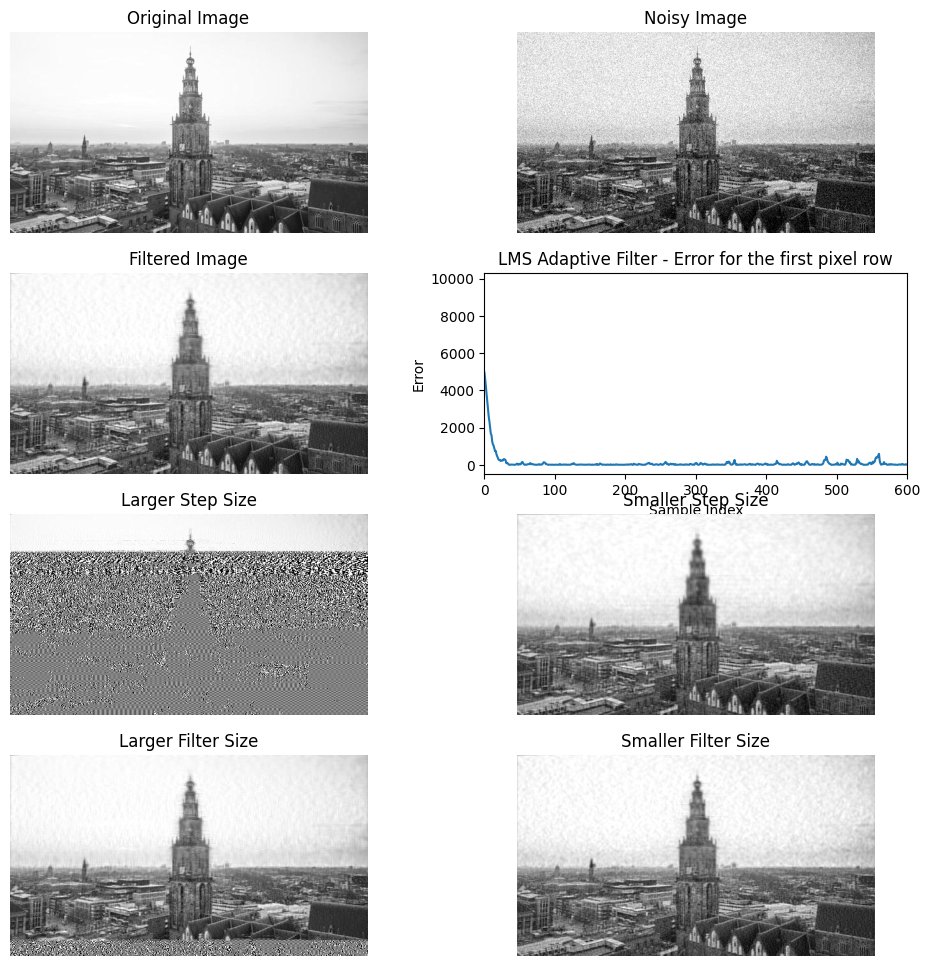

In [42]:
# weights, output, errors = lms_training(input_image, desired_image, 10, 0.00001, 560)
filtered_image, error_history, weights = lms_filter_2d(input_image, desired_image, 7, 0.000001, None)
larger_step, _,_ = lms_filter_2d(input_image, desired_image, 7, 0.00001, None, True)
smaller_step, _,_ = lms_filter_2d(input_image, desired_image, 7, 0.0000001, None)
larger_filter, _,_ = lms_filter_2d(input_image, desired_image, 9, 0.000001, None)
smaller_filter, _,_ = lms_filter_2d(input_image, desired_image, 5, 0.000001, None)

# Reshape the output to the original image shape
output_image = filtered_image.reshape(raw_image.shape)
output_image += np.mean(raw_image)
# Clip values to be in the valid range [0, 255] and convert to uint8
output_image_uint8 = np.clip(output_image, 0, 255).astype(np.uint8)

larger_step = larger_step.reshape(raw_image.shape)
larger_step += np.mean(raw_image)
larger_step = np.clip(larger_step, 0, 255).astype(np.uint8)

smaller_step = smaller_step.reshape(raw_image.shape)
smaller_step += np.mean(raw_image)
smaller_step = np.clip(smaller_step, 0, 255).astype(np.uint8)

larger_filter = larger_filter.reshape(raw_image.shape)
larger_filter += np.mean(raw_image)
larger_filter = np.clip(larger_filter, 0, 255).astype(np.uint8)

smaller_filter = smaller_filter.reshape(raw_image.shape)
smaller_filter += np.mean(raw_image)
smaller_filter = np.clip(smaller_filter, 0, 255).astype(np.uint8)

# Display the original, noisy, and output images
fig, ax = plt.subplots(4, 2, figsize=(12, 12))
ax[0, 0].imshow(raw_image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(noisy_image_uint8, cmap='gray')
ax[0, 1].set_title('Noisy Image')
ax[0, 1].axis('off')

ax[1, 0].imshow(output_image_uint8, cmap='gray')
ax[1, 0 ].set_title('Filtered Image')
ax[1, 0].axis('off')

ax[1, 1].plot(error_history, label='Errors')
ax[1, 1].set_xlabel('Sample Index')
ax[1, 1].set_ylabel('Error')
ax[1, 1].set_title('LMS Adaptive Filter - Error for the first pixel row')
ax[1, 1].set_xlim(0, 600)

# Plot larger_step
ax[2, 0].imshow(larger_step, cmap='gray')
ax[2, 0].set_title('Larger Step Size')
ax[2, 0].axis('off')

# Plot smaller_step
ax[2, 1].imshow(smaller_step, cmap='gray')
ax[2, 1].set_title('Smaller Step Size')
ax[2, 1].axis('off')

# Plot larger_filter
ax[3, 0].imshow(larger_filter, cmap='gray')
ax[3, 0].set_title('Larger Filter Size')
ax[3, 0].axis('off')

# Plot smaller_filter
ax[3, 1].imshow(smaller_filter, cmap='gray')
ax[3, 1].set_title('Smaller Filter Size')
ax[3, 1].axis('off')

plt.show()


# Checking execution time with increasing filter size
The correlation seems to be linear

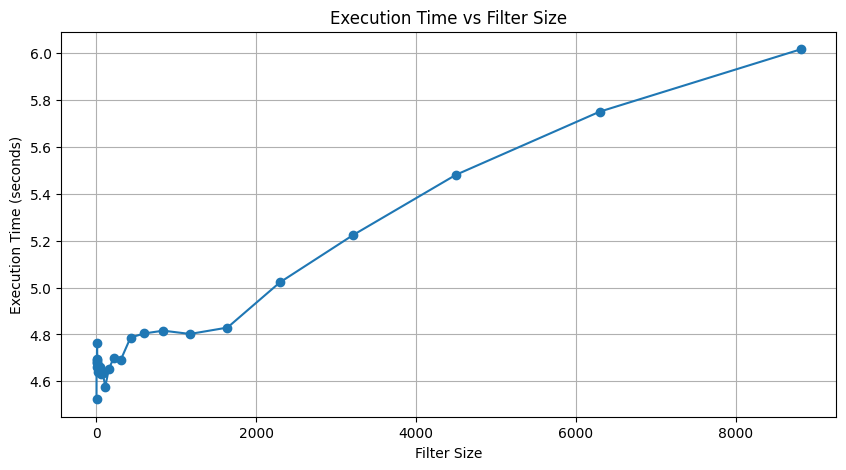

In [43]:
import time

itterations = 28 # 
execution_times = []
x_values = []
for i in range(itterations):
    start_time = time.time()
    filter_size = round(1.4 ** i)
    if filter_size in x_values:
        continue
    filtered_image, error_history, weights = lms_filter_1d(input_image, desired_image, filter_size, 0.000001, None)
    end_time = time.time()
    execution_times.append(end_time - start_time)
    x_values.append(filter_size)

plt.figure(figsize=(10, 5))
plt.plot(x_values, execution_times, marker='o')
plt.xlabel('Filter Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Filter Size')
plt.grid(True)
plt.show()


# check for tap weights

You should not be getting different weights if you run the algorithm multiple times. Only if you get a picture with different noise in it.

[-0.02582167  0.02088827  0.03219516  0.19977552  0.60542133]
[0.01023518 0.00530169 0.00755272 0.00926168 0.00804492]


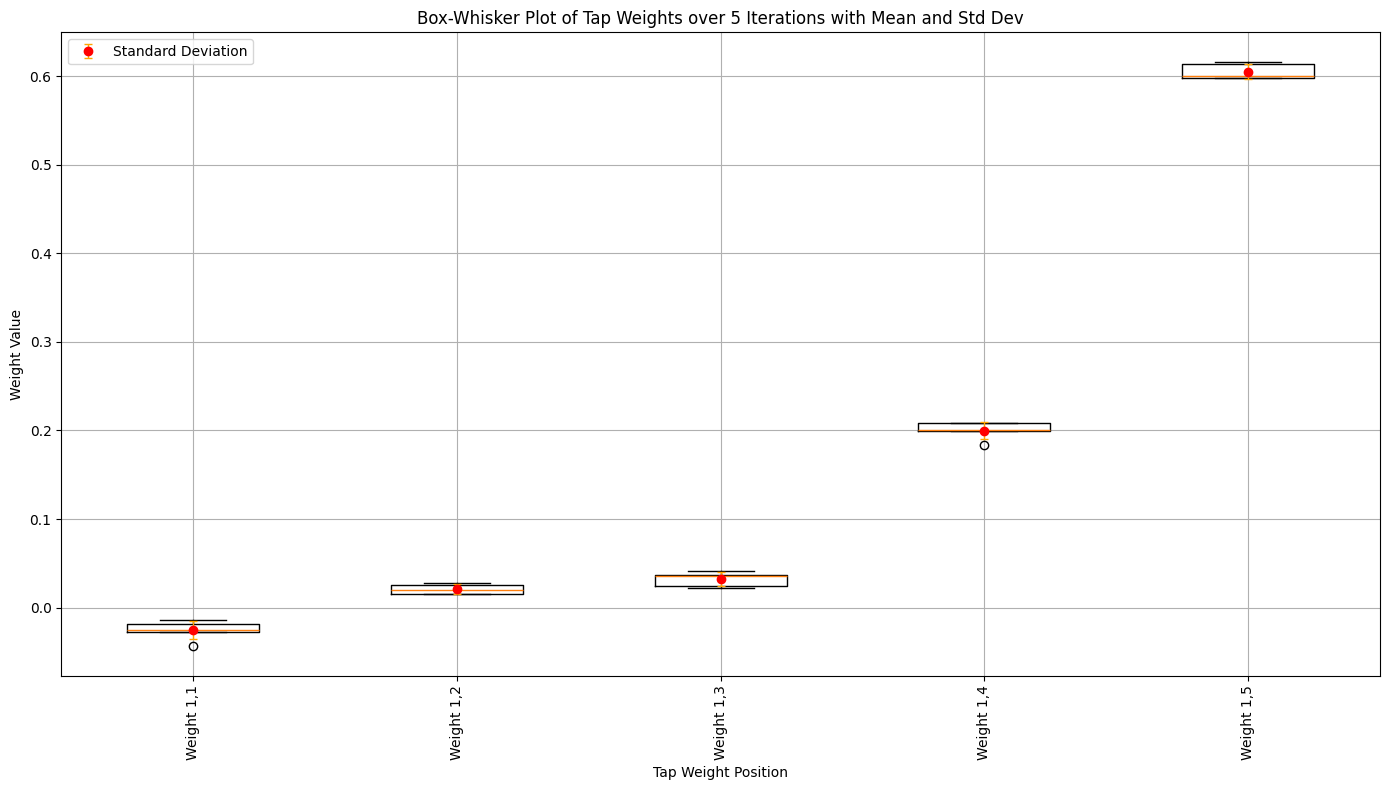

In [44]:
tap_weights = []
itterations = 5
filter_width = 5
desired_image = raw_image - np.mean(raw_image)

for i in range(itterations):
    
    noise_level = 20
    noise = np.random.normal(-noise_level, noise_level, desired_image.shape)
    noisy_image = raw_image + noise

    # Convert noisy_image to uint8 and clip values to be in the valid range [0, 255]
    noisy_image_uint8 = np.clip(noisy_image, 0, 255).astype(np.uint8)

    input_image = desired_image + noise
    filtered_image, error_history, weights = lms_filter_1d(input_image, desired_image, filter_width, 0.000001)
    tap_weights.append(weights)

tap_weights = np.array(tap_weights)  # Shape should be (100, 7) after this conversion

# Transpose to separate each tap weight
tap_weights_reshaped = tap_weights.reshape(itterations, filter_width).T 

mean_values = np.mean(tap_weights_reshaped, axis=1)
std_values = np.std(tap_weights_reshaped, axis=1) 
print(mean_values)
print(std_values)

# Create the boxplot
plt.figure(figsize=(14, 8))
plt.boxplot(tap_weights_reshaped.T, tick_labels=[f'Weight {i//filter_width+1},{i%filter_width+1}' for i in range(filter_width)])
plt.xticks(rotation=90)  # Rotate labels for readability

# Overlay the mean and standard deviation as scatter points
# plt.scatter(range(1, filter_width ** 2 +1), mean_values, color='red', marker='o', label='Mean')
plt.errorbar(range(1, filter_width + 1), mean_values, yerr=std_values, fmt='o', color='red', 
             ecolor='orange', elinewidth=1, capsize=3, label='Standard Deviation')

# Add labels and title
plt.xlabel(f"Tap Weight Position")
plt.ylabel("Weight Value")
plt.title(f"Box-Whisker Plot of Tap Weights over {itterations} Iterations with Mean and Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Same weights and noise, different image

(337, 600)


(-0.5, 599.5, 336.5, -0.5)

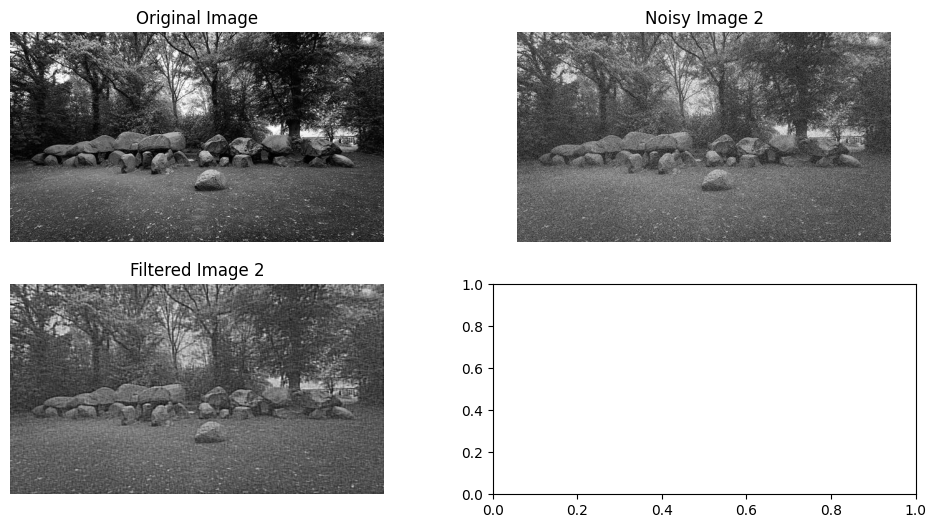

In [45]:
noise_level = 20
noise = np.random.normal(-noise_level, noise_level, (700, 700))
raw_image_shape = raw_image.shape
noise_1 = noise[:raw_image_shape[0], :raw_image_shape[1]]
noisy_image = raw_image + noise_1

# Convert noisy_image to uint8 and clip values to be in the valid range [0, 255]
noisy_image_uint8 = np.clip(noisy_image, 0, 255).astype(np.uint8)
input_image = desired_image + noise_1
filtered_image, error_history, weights = lms_filter_2d(input_image, desired_image, 7, 0.000001)

image_2 = Image.open('test_image_2_bw.jpg')

raw_image_2 = np.array(image_2)
print(raw_image_2.shape)
desired_image_2 = raw_image_2 - np.mean(raw_image_2)

raw_image_shape_2 = raw_image_2.shape
noise_2 = noise[:raw_image_shape_2[0], :raw_image_shape_2[1]]
noisy_image_2 = raw_image_2 + noise_2

input_image_2 = desired_image_2 + noise_2
filtered_image_2, _, _ = lms_filter_2d(input_image_2, desired_image_2, 7, 0.000001, weights, False, False)
filtered_image_2 += np.mean(raw_image_2)

# Display the image
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].imshow(image_2, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(noisy_image_2, cmap='gray')
ax[0, 1].set_title('Noisy Image 2')
ax[0, 1].axis('off')

ax[1, 0].imshow(filtered_image_2, cmap='gray')
ax[1, 0].set_title('Filtered Image 2')
ax[1, 0].axis('off')


# Another method of detecting the error.
It seems the filtered image is a little better than the noisy image.

In [46]:
# Ensure both images are in the same range
image_2_array = np.array(image_2, dtype=np.float64)
noise_image_2_array = np.array(noisy_image_2, dtype=np.float64)
filtered_image_2_array = np.array(filtered_image_2, dtype=np.float64)

# Calculate the normalized difference
normalized_difference = np.abs(image_2_array - filtered_image_2_array) / np.max(np.abs(image_2_array))
normalized_difference_noisy = np.abs(image_2_array - noise_image_2_array) / np.max(np.abs(image_2_array))
print("difference between orginal and noisy image", np.mean(normalized_difference_noisy))
print("difference between orginal and filtered: ", np.mean(normalized_difference))


difference between orginal and noisy image 0.09169575381371604
difference between orginal and filtered:  0.07542728875593645
